<a href="https://colab.research.google.com/github/Vivek-Sajjan/Video_Classification/blob/main/M5_NB_MiniProject_02_Fare_Amount_Prediction_Using_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project: Implementation of Linear Regression on a Large Dataset Using Dask Library

## Learning Objectives

At the end of the mini-project, you will be able to :

- understand how dask handles large dataset over pandas dataframe
- perform exploratory data analysis on a large dataset (2 Million rows) using dask
- implement linear regression model using dask library and make predictions


## Problem Statement

 Predict the taxi fare amount in New York city using Dask-ML.

## Information

### Dask
[Dask](https://dask.pydata.org/en/latest/) is an open source project that gives abstractions over NumPy Arrays, Pandas Dataframes and regular lists, allowing you to run operations on them in parallel, using multicore processing.

We can summarize the basics of Dask as follows:

* processes data that doesn’t fit into memory by breaking it into blocks and specifying task chains

* parallelizes execution of tasks across cores and even nodes of a cluster

* moves computation to the data rather than the other way around, to minimize communication overhead

### Dataset

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. Its variables are as follows:
![Dataset](https://cdn.exec.talentsprint.com/static/cds/NYC_Taxi_data_description_image.png)




Note that the features the ' Dask_MP_dataset.csv' file that is provided for this miniproject varies slightly in terms of included features, as compared to the original dataset described above. Please proceed with the provided csv file.

## Grading = 10 Points

In [1]:
#@title Install Dask dependencies and restart runtime
!pip -qq install dask-ml
!pip -qq install dask
!pip -qq install dask[complete]
!pip install --upgrade --force-reinstall dask distributed
!pip -qq install mimesis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 10.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rapids-dask-dependency 25.2.0 requires dask==2024.12.1, but you have dask 2025.5.0 which is incompatible.
rapids-dask-dependency 25.2.0 requires distributed==2024.12.1, but you have distributed 2025.5.0 which is incompatible.
dask-expr 1.1.21 requires dask==2024.12.1, but you have dask 2025.5.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00
  Using cached dask-2025.5.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached distributed-2025.5.0-py3-none-any.w

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 44.0 MB/s eta 0:00:00


#### Importing Necessary Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error, r2_score
from dask.distributed import Client #sets up a local cluster that utilizes the available cores on your machine
import time as time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dask.distributed import Client, progress
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37581
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40709'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36681'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:37045 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37045
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:48652
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36983 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36983
INFO:distributed.core:Starting established connection to tcp://127

In [2]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv

--2025-05-20 06:07:38--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231900522 (221M) [application/octet-stream]
Saving to: ‘Dask_MP_dataset.csv’

Dask_MP_dataset.csv 100%[===================>] 221.16M  12.1MB/s    in 21s     

2025-05-20 06:08:01 (10.3 MB/s) - ‘Dask_MP_dataset.csv’ saved [231900522/231900522]



#### Exercise 1: Read the dataset using dask library and compare the time of execution with pandas library. (1 Point)

**Hint:** pass `dtype` for passenger_count as `int64`

In [6]:
%%time
# Reading with Dask
start_time_dask = time.time()
df_dask = dd.read_csv("Dask_MP_dataset.csv", dtype={'passenger_count': 'int64'})
end_time_dask = time.time()
dask_read_time = end_time_dask - start_time_dask
print(f"Time taken to read with Dask: {dask_read_time:.4f} seconds")

# Reading with Pandas
start_time_pandas = time.time()
df_pandas = pd.read_csv("Dask_MP_dataset.csv", dtype={'passenger_count': 'int64'})
end_time_pandas = time.time()
pandas_read_time = end_time_pandas - start_time_pandas
print(f"Time taken to read with Pandas: {pandas_read_time:.4f} seconds")

# Comparing times
print(f"\nDask was {pandas_read_time / dask_read_time:.2f} times faster than Pandas for reading this dataset.")

Time taken to read with Dask: 0.0095 seconds
Time taken to read with Pandas: 6.4549 seconds

Dask was 682.16 times faster than Pandas for reading this dataset.
CPU times: user 6.09 s, sys: 614 ms, total: 6.71 s
Wall time: 6.46 s


#### Use pandas to read the dataset and compare the time taken

In [14]:
%%time
df = pd.read_csv("Dask_MP_dataset.csv", dtype={'passenger_count': 'int64'})

CPU times: user 6.73 s, sys: 2.8 s, total: 9.53 s
Wall time: 9.58 s


### Data Analysis



#### Exercise 2: Drop the unnecessary columns. Also drop the duplicate rows and the rows having null values. (1 Point)

**Hint:** Drop those columns which are not useful in EDA as well as model implementation

In [15]:
""" Drop unnecessary columns """
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [16]:
# dropping first column
df = df.drop(df.columns[0], axis=1)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [21]:
""" Drop duplicate rows """
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 122.1+ MB


In [23]:
df.count()

,0
key,2000000
fare_amount,2000000
pickup_datetime,2000000
pickup_longitude,2000000
pickup_latitude,2000000
dropoff_longitude,1999986
dropoff_latitude,1999986
passenger_count,2000000


In [26]:
#drop duplicate rows in dataframe
original_row_count = df.shape[0]
df.drop_duplicates(inplace=True)
rows_removed = original_row_count - df.shape[0]
print(f"Number of duplicate rows removed: {rows_removed}")
df.count()

Number of duplicate rows removed: 0


,0
key,2000000
fare_amount,2000000
pickup_datetime,2000000
pickup_longitude,2000000
pickup_latitude,2000000
dropoff_longitude,1999986
dropoff_latitude,1999986
passenger_count,2000000


In [27]:
""" drop NA rows """
original_row_count_na = df.shape[0]
df.dropna(inplace=True)
rows_removed_na = original_row_count_na - df.shape[0]
print(f"Number of rows with NA values removed: {rows_removed_na}")
df.count()

Number of rows with NA values removed: 14


,0
key,1999986
fare_amount,1999986
pickup_datetime,1999986
pickup_longitude,1999986
pickup_latitude,1999986
dropoff_longitude,1999986
dropoff_latitude,1999986
passenger_count,1999986


#### Exercise 3: Visualize the target variable, i.e., `fare_amount` to study the fare distribution, using a histogram density plot. Analyze the fare_amount distribution, try to visualize it for a range of [0, 60]. (1 Point)

**Hint:** [sns.hisplot()](https://stackoverflow.com/questions/51027636/seaborn-histogram-with-bigdata/51027895) and use `.between` to plot the graph for given range


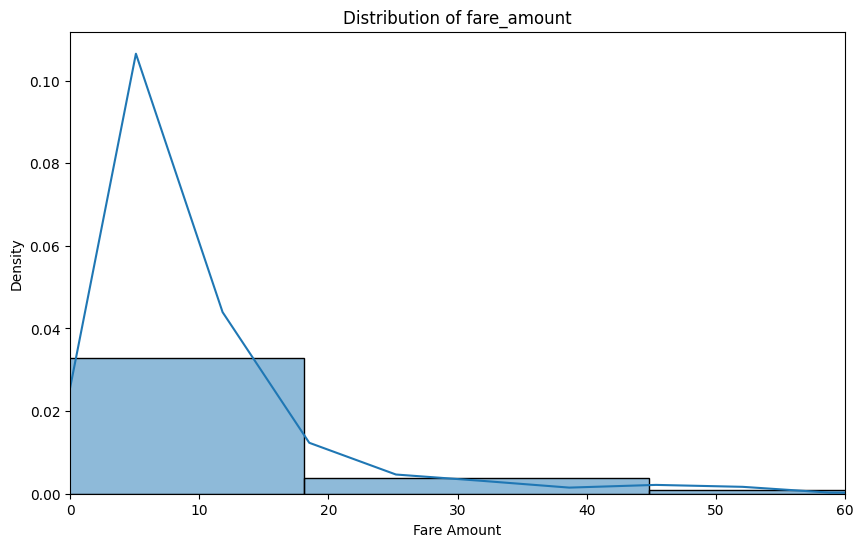

In [30]:
""" explore and plot the density plot of fare_amount """
#import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50,kde=True,stat='density')
plt.title('Distribution of fare_amount')
plt.xlabel('Fare Amount')
plt.ylabel('Density')
plt.xlim(0, 60) # Visualize for the range [0, 60]
plt.show()

#### Observe the number of workers and cores running in your machine

Initialize a client and observe how many workers are working and the number of cores utilizing for the given data set.

In [31]:
""" Initialize a client """
# Get the number of workers
num_workers = len(client.scheduler_info()['workers'])
print(f"Number of workers: {num_workers}")
# Get the total number of cores utilized
total_cores = sum(worker['nthreads'] for worker in client.scheduler_info()['workers'].values())
print(f"Total cores utilized: {total_cores}")

Number of workers: 2
Total cores utilized: 2


### EDA based on Time

#### Exercise 4: Extract day of the week (dow), hour, month and year from `pickup_datetime`. (1 Point)

**Hint:** use `pd.to_datetime()` function as dask does not have this functionality in it.

Remember to use `.compute()` while passing the dask dataframe in defined function.

In [ ]:
# YOUR CODE HERE

#### Exercise 5: a.) Plot the taxi trip by hour of the day  (0.5 Points)

* Partition the data into segments using `dask.from_pandas()`

* Plot the taxi trip for hour of the day. **Hint:** [sns.catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)

In [ ]:
""" taxi trip repartition by hour of the day """
# YOUR CODE HERE

#### Exercise 5: b.) Plot the taxi trip repartition by day of the week (dow) (0.5 Points)

In [ ]:
""" taxi trip repartition by day of the week """
# YOUR CODE HERE

#### Exercise 6: a.) Draw a plot between the target variable and passenger count and analyze it.  (0.5 Points)

In [ ]:
""" passenger count feature """
# YOUR CODE HERE

#### Exercise 6: b.) Draw a plot between the target variable and hour and analyze it. (0.5 Points)

In [ ]:
""" fare amount by hour """
# YOUR CODE HERE

### Feature Engineering

#### Exercise 7: Compute the Haversine distance between pickup and dropoff point. (1 Point)

* Convert the latitude and longitude co-rodinates to radians

* Calculate the Haversine distance

  **Hint:** [haversine_distances](https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4)

* Add the "distance" feature to the dataset and plot its distribution

In [ ]:
""" distance feature """
# YOUR CODE HERE

In [ ]:
""" plot the distance feature (take distance < 50) """
# YOUR CODE HERE

### Show the plot between distance and fare amount

**Hint:** [sns.scatterplot()](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

In [ ]:
""" correlation between fare_amount and distance """
# YOUR CODE HERE

### Preparing dataset for model implementation

**Note:** Use the above modified dataset for modelling.

In [ ]:
# YOUR CODE HERE

### Removing outliers from training set Based on Coordinates

#### Exercise 8: Remove the outliers using the given latitude and longitude features from the dataset. We need to analyze the data of taxi within New York City. (1 Point)

**Hint:** Given the co-ordinates of New York city are Latitude: 40.7128° and Longitude: -74.0060°. You can include the pickup and drop off points such that there left and right value mean will be the given co-ordinate value.

Also, choose nearest extreme values.

Use `.between()` and pass left and right value attributes accordingly.

In [ ]:
""" remove the outliers in pickup latitude longitude and drop off latitude and longitude """
# YOUR CODE HERE

### Modelling

#### Exercise 9: Divide the data into train and test splits with X as feature variables and y as target variable  (1 Point)

* Divide data into train test split with 70-30 ratio, Hint: `train_test_split()`

* As dask functions operate lazily so, before calling `.fit()` function, call the dask dataframe with `.compute()`.
* Convert X_train and y_train into array using `.values` as [dask's](https://ml.dask.org/modules/api.html) `.fit()` function takes array as attribute

In [ ]:
""" select the target and feature variables and split the data into train and test """
# YOUR CODE HERE

#### Exercise 10: Predict the test data and calculate the mean squared error and r2 score. (1 Point)

**Hint:** Remember to call `.compute()` function as dask functions operate lazily and convert the dask dataframe to `.values` (Array type) as suggested in above exercise

In [ ]:
""" predict the values """
# YOUR CODE HERE

In [ ]:
""" compute mean squared error and r2_score """
# YOUR CODE HERE

### Report Analysis
* Discuss the pros and cons of using dask
* Derive the insights and discuss
* Comment on the performance metrics (MSE, $R^2$ score)
